Nodes: 10000, Edges: 50056, Mixing parameter: 0.1, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [01:56<00:00,  2.34s/it]


Nodes: 10000, Edges: 50126, Mixing parameter: 0.2, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.96s/it]


Nodes: 10000, Edges: 49980, Mixing parameter: 0.3, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [02:59<00:00,  3.60s/it]


Nodes: 10000, Edges: 49847, Mixing parameter: 0.4, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [03:11<00:00,  3.83s/it]


Nodes: 10000, Edges: 50216, Mixing parameter: 0.5, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [03:53<00:00,  4.68s/it]


Nodes: 10000, Edges: 49708, Mixing parameter: 0.6, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [02:29<00:00,  2.99s/it]


Nodes: 10000, Edges: 49725, Mixing parameter: 0.7, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [01:48<00:00,  2.18s/it]


Nodes: 10000, Edges: 50000, Mixing parameter: 0.8, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.10s/it]


Nodes: 10000, Edges: 50139, Mixing parameter: 0.9, Number of groups: 100


Computing: 100%|███████████████████████████████████████████████████████████████████████| 50/50 [01:46<00:00,  2.14s/it]


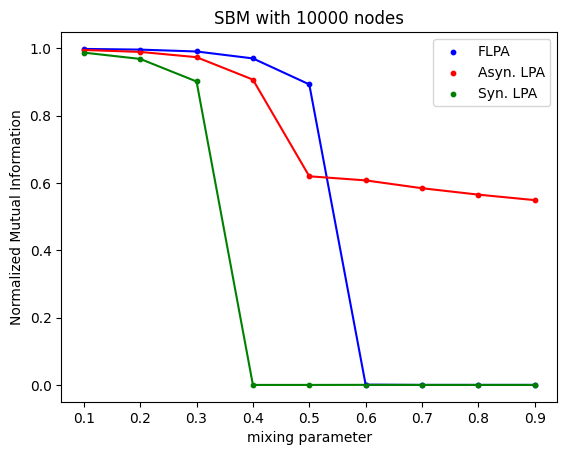

In [2]:
#Plotting the NMI for the LPA asyn., LPA syn., FLPA of a SBM synthetic network
#with increasing mixing parameter and fixed number of nodes, number of groups, average degree.

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm

#Creating the SBM networks
def create_sbm(num_nodes, num_groups, avg_degree, mu):
    #Number of nodes per group
    nodes_per_group = num_nodes // num_groups
    sizes = [nodes_per_group] * num_groups
    
    remainder = num_nodes % num_groups
    for i in range(remainder):
        sizes[i] += 1

    p_in = ((1 - mu) * avg_degree) / (nodes_per_group - 1)  #Probability within a group
    p_out = (mu * avg_degree) / (num_nodes - nodes_per_group)  #Probability between groups

    #Creating the probability matrix
    probs = np.full((num_groups, num_groups), p_out)
    np.fill_diagonal(probs, p_in)  
    
    #Generating the SBM network
    G = nx.stochastic_block_model(sizes, probs, seed=42)
    
    return G  


#Parameters
n= 10000
num_groups = 100
avg_degree = 10
mu_v = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Initializing the variables
group_sizes=int(n/num_groups)
NMI_flpa_av=[]
NMI_lpa_asyn_av=[]
NMI_lpa_syn_av=[]
std_NMI_flpa=[]
std_NMI_lpa_asyn=[]
std_NMI_lpa_syn=[]
h=0

for mu in mu_v:
    G = create_sbm(n, num_groups, avg_degree, mu)
    #Printing parameters of the created network
    print(f"Nodes: {n}, Edges: {G.number_of_edges()}, Mixing parameter: {mu}, Number of groups: {num_groups}")
    
    #true labels of the SBM
    true_labels=[]
    for i in range(num_groups):
        true_labels.extend([i] * group_sizes)

    NMI_flpa=[]
    NMI_lpa_asyn=[]
    NMI_lpa_syn=[]
    for k in tqdm(range(50), desc="Computing"):
        #Computing the communities for each algorithm
        communities_lpa_asyn = list(nx.community.asyn_lpa_communities(G))
        communities_flpa=list(nx.community.fast_label_propagation_communities(G))
        communities_lpa_syn = list(nx.community.label_propagation_communities(G))
        nodes = list(G.nodes())
        
        #Creating a dictionary to map nodes to the communities for each algorithm
        community_labels_lpa_asyn = {}
        for j, community in enumerate(communities_lpa_asyn):
            for node in community:
                community_labels_lpa_asyn[node] = j 
        pred_labels_lpa_asyn = [community_labels_lpa_asyn[node] for node in nodes]
    
        community_labels_lpa_syn = {}
        for j, community in enumerate(communities_lpa_syn):
            for node in community:
                community_labels_lpa_syn[node] = j 
        pred_labels_lpa_syn = [community_labels_lpa_syn[node] for node in nodes]
                
        community_labels_flpa = {}
        for j, community in enumerate(communities_flpa):
            for node in community:
                community_labels_flpa[node] = j 
        pred_labels_flpa = [community_labels_flpa[node] for node in nodes]
    
        NMI_flpa.append(normalized_mutual_info_score(true_labels,pred_labels_flpa))
        NMI_lpa_asyn.append(normalized_mutual_info_score(true_labels,pred_labels_lpa_asyn))
        NMI_lpa_syn.append(normalized_mutual_info_score(true_labels,pred_labels_lpa_syn))

    #Computing averages and standard deviations for each algorithm
    NMI_flpa_av.append(np.mean(NMI_flpa))
    NMI_lpa_asyn_av.append(np.mean(NMI_lpa_asyn))
    NMI_lpa_syn_av.append(np.mean(NMI_lpa_syn))
    std_NMI_flpa.append(np.std(NMI_flpa))
    std_NMI_lpa_syn.append(np.std(NMI_lpa_syn))
    std_NMI_lpa_asyn.append(np.std(NMI_lpa_asyn))
    
    h=h+1

#Plotting the results
plt.scatter(mu_v, NMI_flpa_av,color='blue', label='FLPA',s=10)
plt.plot(mu_v, NMI_flpa_av,linestyle='-',color='blue')
plt.scatter(mu_v, NMI_lpa_asyn_av,color='red', label='Asyn. LPA',s=10)
plt.plot(mu_v, NMI_lpa_asyn_av,linestyle='-',color='red')
plt.scatter(mu_v, NMI_lpa_syn_av,color='green', label='Syn. LPA', s=10)
plt.plot(mu_v, NMI_lpa_syn_av,linestyle='-',color='green')

plt.xlabel('mixing parameter')
plt.ylabel('Normalized Mutual Information')
plt.title(f'SBM with {n} nodes')
plt.legend()
plt.savefig("SBM_NMI.png")
plt.show()